In [1]:
import os.path
import numpy as np
from itertools import cycle
import matplotlib.pyplot as plt
import matplotlib
# matplotlib.use('Qt5Agg')
%matplotlib widget

from pyofss import Domain, System, Gaussian, Fibre, Filter, Splitter
from pyofss import temporal_power, spectral_power, lambda_to_nu, nu_to_lambda
from pyofss import single_plot, map_plot, waterfall_plot, labels
from pyofss.field import energy

OpenclFibre is not activated, check if pyopencl and reikna modules are installed


In [2]:
from pyofss.domain import lambda_to_omega
from pyofss.modules.nonlinearity import calculate_gamma
gamma_passive = calculate_gamma(2.7*(10**(-20)), 37.8, lambda_to_omega(1035))
gamma_active = calculate_gamma(2.7*(10**(-20)), 29, lambda_to_omega(1035))
print("gamma_passive = ", gamma_passive)
print("gamma_active = ", gamma_active)

gamma_passive =  4.336221744085291
gamma_active =  5.652040756083586


In [3]:
domain = Domain(samples_per_bit = 2**14, bit_width = 200.0, total_bits = 1, centre_nu = lambda_to_nu(1035))
gaussian = Gaussian(name="initial_pulse", peak_power = 1, width = 10., C = 50, using_fwhm=True)
A = gaussian.generate(domain.t)
E = energy(A, domain.t)
print("initial energy = ", E)

initial energy =  0.010644670194312263


In [4]:
abs(domain.t[1] - domain.t[0])

0.01220703125

In [5]:
abs(domain.t[100] - domain.t[99])

0.01220703125


Generating single_plot...


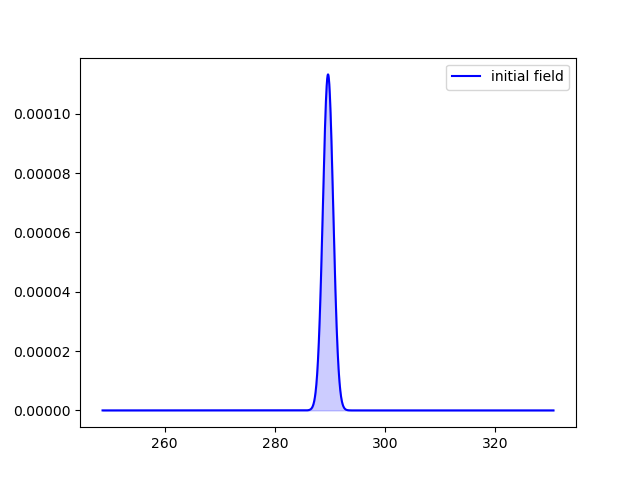

In [6]:
single_plot(domain.nu, spectral_power(A), label="initial field")
# plt.plot(domain.nu, spectral_power(A), label="initial field")

In [7]:
Dir = 'C:/Users/Karin/PycharmProjects/pyofss-master/mamyshev_oscillator/'
sys = System( domain, A)
print("before fibre: Emax(spec)", np.max(spectral_power(sys.field)))
print(f'filter_1: cental_nu = {lambda_to_nu(1040)}')
print(f'filter_2: cental_nu = {lambda_to_nu(1030)}')

for i in range(50):
    cycleDir = os.path.join(Dir, f'cycle{int(i)}')
    sys.add(Filter(name="filter_1", width_nu=(Domain.vacuum_light_speed/(1040**2))*4, offset_nu=(lambda_to_nu(1040) - lambda_to_nu(1035)),
                    m=1, channel=0, using_fwhm=False, type_filt = "reflected"))
    sys.add(Splitter(name="splitter", loss = 0.55))
    sys.add(Fibre(name="passive_fibre_1", length=0.8*1e-3, gamma=gamma_passive, beta=np.array([0, 0, 22.2]), total_steps=1000, traces=100, method='ss_symmetric', dir = os.path.join(cycleDir, "passive_fibre_1")))
    sys.add(Fibre(name="active_fibre_1", length=2.5*1e-3, gamma=gamma_active, beta=np.array([0, 0, 24.9]), total_steps=1000, traces=100, method='ss_symmetric', small_signal_gain = 25, E_sat = 25.0,  dir = os.path.join(cycleDir, "active_fibre_1")))
    sys.add(Fibre(name="passive_fibre_2", length=0.8*1e-3, gamma=gamma_passive, beta=np.array([0, 0, 22.2]), total_steps=1000, traces=100, method='ss_symmetric', dir = os.path.join(cycleDir, "passive_fibre_2")))
    sys.add(Splitter(name="splitter", loss = 0.6))
    sys.add(Filter(name="filter_2", width_nu=(Domain.vacuum_light_speed/(1030**2))*4, offset_nu=(lambda_to_nu(1030) - lambda_to_nu(1035)),
                    m=1, channel=0, using_fwhm=False, type_filt = "reflected"))
    sys.add(Splitter(name="splitter", loss = 0.55))
    sys.add(Fibre(name="passive_fibre_3", length=0.8*1e-3, gamma=gamma_passive, beta=np.array([0, 0, 22.2]),  total_steps=1000, traces=100, method='ss_symmetric', dir = os.path.join(cycleDir, "passive_fibre_3")))
    sys.add(Fibre(name="active_fibre_2", length=2.5*1e-3, gamma=gamma_active, beta=np.array([0, 0, 24.9]), total_steps=1000, traces=100, method='ss_symmetric', small_signal_gain = 25, E_sat = 36., dir = os.path.join(cycleDir, "active_fibre_2")))
    sys.add(Fibre(name="passive_fibre_4", length=0.8*1e-3, gamma=gamma_passive, beta=np.array([0, 0, 22.2]), total_steps=1000, traces=100, method='ss_symmetric', dir = os.path.join(cycleDir, "passive_fibre_4")))
    sys.add(Splitter(name="splitter", loss = 0.8*1e-3))

   
sys.run()
sys['passive_fibre_1'].print_refrence_length(domain, A)


c:\Users\Karin\PycharmProjects\pyofss-master\pyofss\modules\storage.py:108: UserWarning: Directory is not empty
  warnings.warn("Directory is not empty")


before fibre: Emax(spec) 0.00011328634854124568
filter_1: cental_nu = 288.26197884615385
filter_2: cental_nu = 291.0606388349514
Directory:  C:/Users/Karin/PycharmProjects/pyofss-master/mamyshev_oscillator/cycle0\passive_fibre_1  found...
Directory:  C:/Users/Karin/PycharmProjects/pyofss-master/mamyshev_oscillator/cycle0\active_fibre_1  found...
Directory:  C:/Users/Karin/PycharmProjects/pyofss-master/mamyshev_oscillator/cycle0\passive_fibre_2  found...
Directory is empty OK
Directory:  C:/Users/Karin/PycharmProjects/pyofss-master/mamyshev_oscillator/cycle0\passive_fibre_3  found...
Directory is empty OK
Directory:  C:/Users/Karin/PycharmProjects/pyofss-master/mamyshev_oscillator/cycle0\active_fibre_2  found...
Directory is empty OK
Directory:  C:/Users/Karin/PycharmProjects/pyofss-master/mamyshev_oscillator/cycle0\passive_fibre_4  found...
Directory is empty OK
Directory:  C:/Users/Karin/PycharmProjects/pyofss-master/mamyshev_oscillator/cycle1\passive_fibre_1  found...
Directory is em

  0%|          | 0/1000 [00:00<?, ?it/s]

Caching linear factor


 18%|█▊        | 176/1000 [00:10<00:48, 16.98it/s]


KeyboardInterrupt: 


Generating single_plot...
after fibre, Emax(spec) =  0.00011327104719192834
max is 289.65454879227053 nu


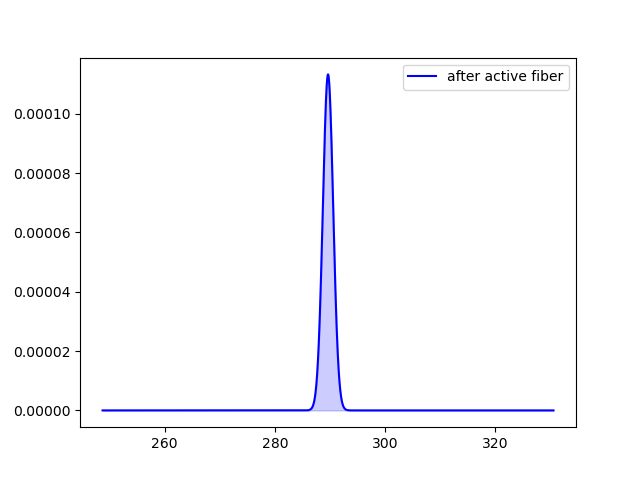

In [14]:
single_plot(domain.nu, spectral_power(sys.field), label="after active fiber")
print("after fibre, Emax(spec) = ", np.max(spectral_power(sys.field)))
print(f"max is {domain.nu[np.argmax(spectral_power(sys.field))]} nu")


Generating single_plot...
before fibre, Emax(spec) =  0.00011328634854124568
max is 289.65454879227053 nu


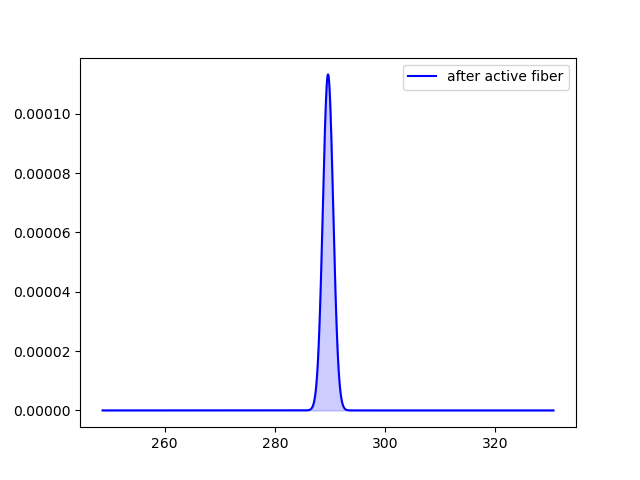

In [13]:
single_plot(domain.nu, spectral_power(A), label="after active fiber")
print("before fibre, Emax(spec) = ", np.max(spectral_power(A)))
print(f"max is {domain.nu[np.argmax(spectral_power(A))]} nu")


Generating single_plot...
after fibre, Emax(temp) =  1157.318867501678
max is 0.634765625 t


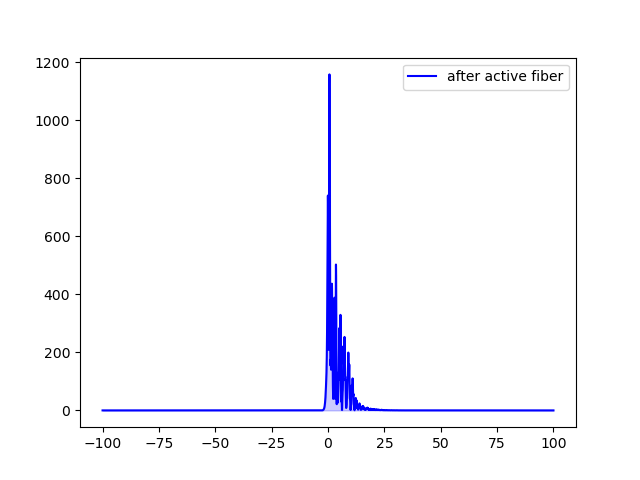

In [9]:
single_plot(domain.t, temporal_power(sys.field), label="after active fiber")
print("after fibre, Emax(temp) = ", np.max(temporal_power(sys.field)))
print(f"max is {domain.t[np.argmax(temporal_power(sys.field))]} t")

In [15]:
E = energy(A, domain.t)
print("total pulse energy before fiber, Etot = ", E)

total pulse energy before fiber, Etot =  0.010644670194312263


In [8]:
dir = 'C:/Users/Karin/PycharmProjects/pyofss-master/amplification_fiber1'
storage = sys['active_fibre_1'].stepper.storage
# (x, y, z) = storage.get_plot_data()
storage.draw_animation()

In [11]:
storage.save_all_storage_to_dir(dir = dir)

Directory:  C:/Users/Karin/PycharmProjects/pyofss-master/amplification_fiber1  found...


c:\Users\Karin\PycharmProjects\pyofss-master\pyofss\modules\storage.py:97: UserWarning: Directory is not empty
  warnings.warn("Directory is not empty")


storage.draw_animation()

In [16]:
single_plot(domain.t, temporal_power(sys.field), label="after active fiber")
print("peak pulse energy after fibre, Emax = ", np.max(temporal_power(sys.field)))


Generating single_plot...
peak pulse energy after fibre, Emax =  0.3549839304204999
